<a href="https://colab.research.google.com/github/punkmic/unsupervised-Sentiment-Analysis---Comparisen-analysis/blob/master/Unsupervised_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**

## **Install Dependecies**

In [89]:
%%capture
# install dependecies here
#!pip install langdetect  # for language detection
#!pip install diagrams # for visualize the workflow
#!pip install graphviz # for visualize the workflow
#!pip install Pillow # for image manipulation
!pip install textblob # for unsupervised sentiment analysis
!pip install wordcloud # for wordcloud plot
!pip install matplotlib # for plot
!pip install nltk # for natural language prepocessing
!pip install enelvo # for fix slangs, abbreviations, spelling errors
!pip install gensim # for topic modeling 
!pip install tabulate # for print as table
#!pip install transformers # for machine learning
!pip install numpy==1.21.6 # for mathematical
!pip install pyldavis # for model visualization
!pip install scikit-learn # machine learning

## **Load Depencies**

In [198]:
%%capture
# load dependecies here
#from langdetect import detect as dt
#from diagrams import Diagram as dg
#from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
sw = nltk.corpus.stopwords.words('portuguese')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("portuguese")
from nltk.tokenize import RegexpTokenizer
wnl = WordNetLemmatizer()
import scipy
from scipy import spatial
import re
from textblob import TextBlob
from textblob import Word
import gensim
from gensim.models import Word2Vec
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.cluster
from sklearn.cluster import KMeans
from enelvo.normaliser import Normaliser
# We need this dataset in order to use the tokenizer


## **Load Dataset**

### **Clone Github repository** 

In [91]:
# Files cloned from github may not automatically appear in files tab in this case right click and choose update
# this will update our files.
!git clone https://github.com/punkmic/unsupervised-Sentiment-Analysis---Comparisen-analysis.git
%cd /content/unsupervised-Sentiment-Analysis---Comparisen-analysis
!ls

Cloning into 'unsupervised-Sentiment-Analysis---Comparisen-analysis'...
remote: Enumerating objects: 14294, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 14294 (delta 42), reused 82 (delta 29), pack-reused 14181
Receiving objects: 100% (14294/14294), 107.41 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (1190/1190), done.
Checking out files: 100% (13643/13643), done.
/content/unsupervised-Sentiment-Analysis---Comparisen-analysis
app.py		   README.md
clear_datasets.py  requirements.txt
clusters	   results
Drivers		   unsupervised-Sentiment-Analysis---Comparisen-analysis
LICENSE		   Unsupervised_Sentiment_Analysis.ipynb
Makefile	   webscraping.py
__pycache__	   wordclouds


In [92]:
# !git pull 

### **Load csv file**

In [134]:
PATH_TO_CSV = '/content/unsupervised-Sentiment-Analysis---Comparisen-analysis/results/web_scraping_results.csv'
df = pd.read_csv(PATH_TO_CSV, encoding='utf-8')
# lower colnames 
df.rename(columns={'Title':'title', 'Body':'body'}, inplace=True)

### **EDA**

In [94]:
print(f'Number of rows {df.shape[0]} \nNumber of columns {df.shape[1]}')

Number of rows 10 
Number of columns 2


In [95]:
print(df.dtypes)

title    object
body     object
dtype: object


In [96]:
from numpy import mean, median
text_length_list = df['body'].map(lambda x: len(x))
mean = mean(text_length_list)
median = median(text_length_list)
stats = df.describe(include='all')
print (f'Mean of sentences length: {mean} \nMedian of sentences length: {median} \n\n{stats}')

Mean of sentences length: 448.7 
Median of sentences length: 448.0 

                                                    title  \
count                                                  10   
unique                                                 10   
top     Recebi um e-mail que parte do pedido não foi p...   
freq                                                    1   

                                                     body  
count                                                  10  
unique                                                 10  
top     Olá!Preciso da ajuda de vocês para entender qu...  
freq                                                    1  


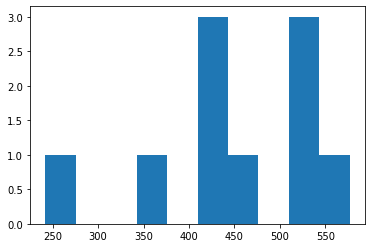

In [97]:
plt.hist(text_length_list)
plt.show()

## **Plot wordcloud**

In [98]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [99]:
# print currently directory
!pwd

/content/unsupervised-Sentiment-Analysis---Comparisen-analysis


In [ ]:
%%capture
# Create and generate a word cloud image:
text = str(df['body']).title()
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)

# Save wordcloud 
if not os.path.exists("wordclouds/raw/"):
  os.makedirs("wordclouds/raw/")
wordcloud.to_file('wordclouds/raw/body_wordcloud.png')

# Display wordcloud
plt.figure()
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



## **Text Pre-Processing**

Guide
* Lower Case conversion
* Removing Punctuations
* Stop Words Removal
* Rare Words Removal
* Spelling correction
* Tokenization
* Lemmatization



### **Apply enelvo - Normalize noisy words, lowercase the words and remove punctuation.**
Enelvo is a tool for normalising noisy words in user-generated content written in Portuguese -- such as tweets, blog posts, and product reviews. It is capable of identifying and normalising spelling mistakes, internet slang, acronyms, proper nouns, and others.

In [135]:
norm = Normaliser(tokenizer='readable', sanitize=True)
stemmer = SnowballStemmer('portuguese')

### **Process text**

In [136]:
def text_processing(df):
   # lower text
   df['body']= df['body'].apply(lambda x: ' '.join([x.lower() for x in x.split()]))
   # removal of stop words
   df['body'] = df['body'].apply(lambda x: ' '.join([x for x in x.split() if x not in sw]))
   # spelling Correction
   df['body'] = df['body'].apply(lambda x: norm.normalise(x) )
   # remove punctuations
   df['body'] = df['body'].str.replace('[^\w\s]', '')
   # removal of Numeric
   df['body'] = df['body'].str.replace('[0-9]', '')
   return df

In [137]:
df = text_processing(df)
df['body'][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


'olá preciso ajuda entender problema recebi email uns itens pagos fiz compra valor ar   cobrado cartão verificar itens deste pedido aparece valor ar   então parece pago dizem foi tão puderem estornar valor cobrado precisa enviar sabonetes obrigada'

## **Feature engineer**

### **Count vectors**

In [138]:
cv = CountVectorizer()
cv.fit(df['body'])
cv_tedfeatures = cv.transform(df['body'])
print(f"samples: {cv_tedfeatures.shape[0]}, features: {cv_tedfeatures.shape[1]}")
print()
df_bow_sklearn = pd.DataFrame(cv_tedfeatures.toarray(),columns=cv.get_feature_names_out())
df_bow_sklearn.head()

samples: 10, features: 279



,absolutamente,acer,acessar,acesso,acordo,ado,agora,agosto,aguardo,ai,...,vem,venho,verificar,verificação,video,vier,vieram,vinculada,volta,vídeos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,2,0,0,1,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### **TF-IDF Vectors**

In [139]:
tv = TfidfVectorizer()
tv.fit(df['body'])
tv_tedfeatures = tv.transform(df['body'])
print(f"samples: {tv_tedfeatures.shape[0]}, features: {tv_tedfeatures.shape[1]}")
print()
# convert sparse matrix to dense
dense = tv_tedfeatures.todense()
denselist = dense.tolist()
tfid_df = pd.DataFrame(denselist,columns=tv.get_feature_names_out())
tfid_df.head()

samples: 10, features: 279



,absolutamente,acer,acessar,acesso,acordo,ado,agora,agosto,aguardo,ai,...,vem,venho,verificar,verificação,video,vier,vieram,vinculada,volta,vídeos
0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.156735,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.133985,0.00000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.1139,0.000000
2,0.155454,0.0,0.000000,0.000000,0.000000,0.13215,0.155454,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.155454
3,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.157087,0.0,...,0.0,0.314174,0.000000,0.000000,0.157087,0.0,0.0,0.000000,0.0000,0.000000
4,0.000000,0.0,0.130755,0.130755,0.000000,0.00000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.130755,0.000000,0.0,0.0,0.130755,0.0000,0.000000


## **K-means Clustering**

### **Vectors as features**

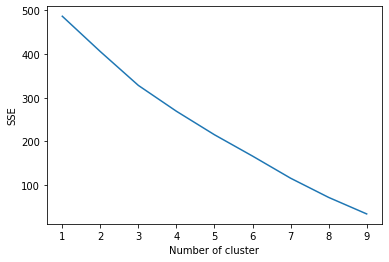

In [140]:
# Elbow method 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
elbow_method = {}
for k in range(1, 10):
  kmeans_elbow = KMeans(n_clusters=k).fit(cv_tedfeatures)
  elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [141]:
# Silhouette method 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
for n_cluster in range(2, 10):
  kmeans = KMeans(n_clusters=n_cluster).fit(cv_tedfeatures)
  label = kmeans.labels_
  sil_coeff = silhouette_score(cv_tedfeatures, label, metric='euclidean')
  print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")

For n_clusters=2, The Silhouette Coefficient is 0.05909389105900096
For n_clusters=3, The Silhouette Coefficient is 0.06612357145683898
For n_clusters=4, The Silhouette Coefficient is 0.011905978879828636
For n_clusters=5, The Silhouette Coefficient is 0.03524973495885201
For n_clusters=6, The Silhouette Coefficient is 0.03389646558179478
For n_clusters=7, The Silhouette Coefficient is 0.03239078472322965
For n_clusters=8, The Silhouette Coefficient is 0.030419304786093983
For n_clusters=9, The Silhouette Coefficient is 0.0042727099432998406


### **TF-IDF as features**

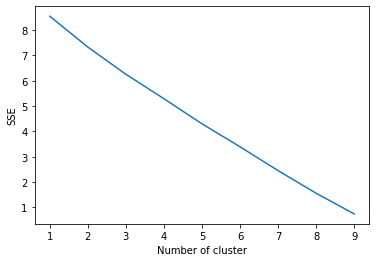

In [108]:
# Elbow method 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
elbow_method = {}
for k in range(1, 10):
  kmeans_elbow = KMeans(n_clusters=k).fit(tv_tedfeatures)
  elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [109]:
# Silhouette method 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
for n_cluster in range(2, 10):
  kmeans = KMeans(n_clusters=n_cluster).fit(tv_tedfeatures)
  label = kmeans.labels_
  sil_coeff = silhouette_score(cv_tedfeatures, label, metric='euclidean')
  print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")

For n_clusters=2, The Silhouette Coefficient is 0.047257637963629306
For n_clusters=3, The Silhouette Coefficient is 0.03532328315479835
For n_clusters=4, The Silhouette Coefficient is 0.053771569159734835
For n_clusters=5, The Silhouette Coefficient is 0.03407575302246654
For n_clusters=6, The Silhouette Coefficient is 0.02504314381813117
For n_clusters=7, The Silhouette Coefficient is 0.021510675877519182
For n_clusters=8, The Silhouette Coefficient is -0.024882694140998102
For n_clusters=9, The Silhouette Coefficient is -0.0015142821880752139


### **Clustering Mode**l

In [142]:
# define how many clusters K-means will generate
NUMBER_OF_CLUSTERS = 4
RANDOM_STATE = 20
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS).fit(tv_tedfeatures)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of cluster {kmeans.n_clusters} \nNumber of elements asigned to each cluster: {cluster_sizes} ")

Number of cluster 4 
Number of elements asigned to each cluster: [2 4 3 1] 


In [143]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print(f'\nCluster {i}')
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [144]:
clusters = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE).fit_predict(tv_tedfeatures)
get_top_keywords(tv_tedfeatures, clusters, tv.get_feature_names_out(), 10)


Cluster 0
prazo,correios,automático,devolver,código,dinheiro,dias,devolução,ainda,produto

Cluster 1
site,amazon,consigo,telefone,cadastro,opção,tudo,número,conta,cancelar

Cluster 2
seguinte,nova,sendo,ok,recebe,entregador,fazer,vieram,dia,entrega

Cluster 3
digital,deste,cobrando,cobrado,itens,venho,assinatura,cobrança,ar,valor


### **PCA and TSNE**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=tv_tedfeatures.shape[0], replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=2).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=tv_tedfeatures.shape[0], replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tv_tedfeatures, clusters)

In [114]:
ted_segmentaion = {'body':  df['body'] , 'cluster': kmeans.labels_.tolist()}
clusters_df = pd.DataFrame(ted_segmentaion)
clusters_df['cluster'] = kmeans.labels_.tolist()
clusters_df.head()


,body,cluster
0,olá preciso ajuda entender problema recebi ema...,1
1,comprei perfume recebi produto vale nada cheir...,2
2,novamente casa terminei assistir serie anéis p...,1
3,fiz assinatura amazon prime video valor ar v...,1
4,prezados te hot conta amazon fiz compras anter...,3
5,requeri devolução produto ainda sete dias aten...,2
6,fiz compra brinquedo transportadora conseguira...,2
7,tentando cancelar assinatura discovery amazon ...,3
8,comprei carregador fonte carregador notebook a...,2
9,fiz compra amazon aonde previsão entrega ambos...,0


### **Visualization of clusters**

In [145]:
%%capture
# cluster 1 visualization
from wordcloud import WordCloud, STOPWORDS
def generate_wordcloud_by_cluster(index, cluster):
# Mono Gram
  wordcloud = WordCloud(max_font_size=50, max_words=20, collocations = False).generate_from_text(' '.join(cluster['body']))
  
  # save wordcloud
  # Save wordcloud 
  if not os.path.exists("wordclouds/clusters/"):
    os.makedirs("wordclouds/clusters/")
  wordcloud.to_file(f'wordclouds/clusters/{index}_cluster_wordcloud.png')
  
  # Generate plot
  plt.figure(figsize=(8,3))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

# generate wordcloud for the first two clusters
for index in range(2):
  cluster = clusters_df[clusters_df.cluster == index]
  generate_wordcloud_by_cluster(index,cluster)

## **Topic Modeling**

### **Create a dictionary using the bag of words model**
- Document: some text.
- Corpus: a collection of documents.

In [214]:
def preprocess_data(doc_set):
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('portuguese'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = SnowballStemmer(language = 'portuguese')
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens 
        stopped_tokens = [i for i in tokens if not i in en_stop ]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [215]:
def prepare_corpus(doc):
    # associate each word in the corpus with a unique integer ID.
    dictionary = corpora.Dictionary(doc)
    
    # create the bag-of-word representation for documents (corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc]
    return dictionary, doc_term_matrix

### **Latent Dirichlet Allocation (LDA) model**

In [216]:
from gensim import models
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

def create_gensim_lda_model(doc_clean, number_topics, words):
  
  dictionary, doc_term_matrix = prepare_corpus(doc_clean) 

  # train model
  lda_model = models.ldamodel.LdaModel(corpus=doc_clean,
            id2word=dictionary,
            num_topics=num_topics,
            eval_every=10)
  
  print(lda_model.print_topics(num_topics=number_topics, num_words=words))

  # Save models so they aren't lost
  #if not os.path.exists(f"models/lda/lda_{iterations}i{passes}p_cluster{cluster_index}/"):
    #os.makedirs(f"models/lda/lda_{iterations}i{passes}p_cluster{cluster_index}/")

  #lda_model.save(f"models/lda/lda_{iterations}i{passes}p_cluster{cluster_index}/lda_{iterations}i{passes}p.model")
    
  #print(f'Model saved at: ./models/lda/lda_{iterations}i{passes}p_cluster{cluster_index}/lda_{iterations}i{passes}p.model')

  return lda_model

In [208]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary) 
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [209]:
def plot_graph(doc_clean, start, stop, step):
    
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [218]:
num_topics = 5
iterations = 50
passes = 50
words=10

for index in range(kmeans.n_clusters):
  cluster = clusters_df[clusters_df.cluster == index]
  doc_clean = preprocess_data(cluster.body)
  lda_model = create_gensim_lda_model(doc_clean, num_topics, words)

  # plot coherence score
  start,stop,step=2,12,1
  plot_graph(doc_clean, start, stop, step)

ValueError: ignored

### **Visualization of topics**

In [149]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
import warnings
import IPython
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [154]:
def save_topics_html(path, model, doc, dictionary):
  if not os.path.exists(f'topics/'):
    os.makedirs(f'topics/')
  return gensimvis.prepare(model, doc, dictionary)


In [156]:
# save lda models clusters topics
for index in range(kmeans.n_clusters):
  lda = lda_models[index]
  bow = bows[index]
  dictionary = dictionaries[index]
  vis = save_topics_html(path, lda, bow, dictionary)
  pyLDAvis.save_html(vis, f'topics/lda_topics_cluster_{index}.html')
  print(f'Visualization saved at: topics/lda_topics_cluster_{index}.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Visualization saved at: topics/lda_topics_cluster_0.html
Visualization saved at: topics/lda_topics_cluster_1.html
Visualization saved at: topics/lda_topics_cluster_2.html
Visualization saved at: topics/lda_topics_cluster_3.html


In [159]:
# show cluster topics
IPython.display.HTML(filename='topics/lda_topics_cluster_1.html')

### **Evaluating LDA model**

In [175]:
data = []
for index in range(kmeans.n_clusters):
  lda = lda_models[index]
  tokens = tokens_filtered[index]
  dictionary = dictionaries[index]
  bow = bows[index]
  # perplexity is the measure of uncertainty, meaning lower the perplexity better the model.
  perplexity = lda.log_perplexity(bow)
  # Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
  coherence_model_lda = models.CoherenceModel(model=lda, texts=tokens, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
    
  data.append([index, perplexity, coherence_lda])
  
df = pd.DataFrame(data, columns = ['cluster','perplexity', 'coherence_score'])

path = './models/lda/evaluation/'
if not os.path.exists(path):
  os.makedirs(path)
df.to_csv(f'{path}evaluation.csv')

print('File saved at: ./models/lda/evaluation/evaluation.csv')
df.head()

File saved at: ./models/lda/evaluation/evaluation.csv


,cluster,perplexity,coherence_score
0,0,-4.390440,1.000000
1,1,-5.177459,0.615229
2,2,-5.212714,0.733570
3,3,-4.844161,0.823320


### **Latent Semantic Analysis (LSA) model** 

In [196]:
for index in range(len(tfidf_models)):
  model = tfidf_models[index]
  tfidf_corpus = tfidf_model[bows[index]]
  dictionary = dictionaries[index]
  tokens = tokens_filtered[index]
  
  # train model
  lsa_model = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=5)

  # Save models so they aren't lost
  if not os.path.exists(f"models/lsa/lsa_cluster{index}/"):
    os.makedirs(f"models/lsa/lsa_cluster{index}/")

  lsa_model.save(f"models/lsa/lsa_cluster{index}/lsa.model")
    
  print('Models saved at: ./models/lsa')

  #print the score and topics for each document in corpus sorted by topic score
  print(f'Cluster {index}')
  for index in range(len(tfidf_corpus)):
    for index, score in sorted(lsa_model[tfidf_corpus[index]], key=lambda x:x[1], reverse=True):
      print(f"\nScore: {score}\t \nTopic: {lsa_model.print_topic(index,5)}")
      print()

Models saved at: ./models/lsa
Cluster 0

Score: 1.0000000000000004	 
Topic: 0.513*"entrega" + 0.410*"dia" + 0.308*"vieram" + 0.205*"ok" + 0.205*"sendo"

Models saved at: ./models/lsa
Cluster 1

Score: 0.6979305063591962	 
Topic: 0.546*"valor" + 0.424*"ar" + 0.254*"amazon" + 0.254*"assinatura" + 0.214*"cobrança"


Score: 0.3879748693438477	 
Topic: -0.331*"ar" + -0.280*"assinatura" + -0.280*"amazon" + 0.224*"cobrado" + 0.224*"iten"


Score: -0.601970521745726	 
Topic: 0.244*"cobrança" + -0.202*"ar" + -0.186*"cobrado" + -0.186*"iten" + -0.186*"pago"


Score: 0.7561237456138195	 
Topic: 0.244*"cobrança" + -0.202*"ar" + -0.186*"cobrado" + -0.186*"iten" + -0.186*"pago"


Score: 0.5864948238165664	 
Topic: 0.546*"valor" + 0.424*"ar" + 0.254*"amazon" + 0.254*"assinatura" + 0.214*"cobrança"


Score: 0.29034583336997233	 
Topic: -0.331*"ar" + -0.280*"assinatura" + -0.280*"amazon" + 0.224*"cobrado" + 0.224*"iten"


Score: 0.8569382168905536	 
Topic: 0.546*"valor" + 0.424*"ar" + 0.254*"amazon" + 

In [ ]:
# print the weight of each word in one document sorted by weight
table = []
for id, weight in sorted(lsa_model[corpus[2]], key=lambda x: x[1], reverse=True):
    word = dictionary[id]
    table.append([word, weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

In [ ]:
# Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
coherence_model_lsa = models.CoherenceModel(model=lsa_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

### **Random Projections, RP**

In [ ]:
num_topics = len(dictionary)
rp_model = models.RpModel(tfidf_corpus, num_topics=num_topics)

In [ ]:
# print the weight of each word in one document sorted by weight
table = []
for id, weight in sorted(rp_model[tfidf_corpus[5]], key=lambda x: x[1], reverse=True):
    word = dictionary[id]
    table.append([word, weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

### **Hierarchical Dirichlet Process, HDP** 

In [ ]:
hp_model = models.HdpModel(corpus, id2word=dictionary)

In [ ]:
table = []
for id, weight in sorted(hp_model[corpus[5]], key=lambda x: x[1], reverse=True):
  word = dictionary[id]
  table.append([word,weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

In [ ]:
# Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
coherence_model_hp = models.CoherenceModel(model=hp_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_hp = coherence_model_hp.get_coherence()
print('Coherence Score: ', coherence_hp)

### **BERTimbau**

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
# BERT Base
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

### **Texblob**

In [ ]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def get_blob_sentiment(sentence):
  blob = TextBlob(sentence).sentiment
  return blob.polarity

### **Vader**

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
def get_vader_sentiment(sentence):
  vader = sid.polarity_scores(sentence)
  return vader['compound']

In [ ]:
df['TextBlob'] = df['body'].apply(lambda sentence: get_blob_sentiment(sentence))
df['Vader'] = df['body'].apply(lambda sentence: get_vader_sentiment(sentence))

A negative sentiment score means 
negative sentiment, and a positive sentiment score means positive sentiment. The higher 
the absolute value of the score, the more confident the system is about it

In [ ]:
df.head(10)

### **Clustering sentences with K-Means**

In [ ]:
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split

## **Save Models to Google Cloud Storage**

In [ ]:
# import google cloud dependencies
#from google.colab import auth
#import uuid # for generate a unique identification for google bucket
# Define a project id in google cloud
#project_id = '<project_ID>'

#auth.authenticate_user()
# configure gsutil
## !gcloud config set project {project_id}
# set bucket name
##backet_name = f'sample-bucket-{uuid.uuid1()}'
## !gsuit mb gs://{bucket_name}

In [ ]:
# upload model to Google Cloud Storage
#!gsuit cp /tmp/name_of_file.txt gs://{bucket_name}/

# location of model
#download_location = f"https://console.cloud.google.com/storage/browser?project={project_id}"

# donwload model from Google Cloud Storage
#!gsuit cp gs://{bucket_name}/{filename} {download_location}

## **References**


[LangDetect](https://pypi.org/project/langdetect/) <br/>
[Diagrams](https://pypi.org/project/diagrams/) <br/>
[Graphviz](https://pypi.org/project/graphviz/) <br/>
[Beautifulsoap4](https://pypi.org/project/beautifulsoup4/) <br/>
[OpLexicon](https://www.inf.pucrs.br/linatural/wordpress/recursos-e-ferramentas/oplexicon/)